In [2]:
import tensorflow as tf

In [3]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import os
import glob

import SimpleITK as sitk

from PIL import Image

from scipy.misc import imread

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

In [5]:
annotations = pd.read_csv('../src/data/annotations.csv')
candidates = pd.read_csv('../src/data/candidates.csv')

In [6]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [7]:
print("1   ", len(candidates[candidates['class'] == 1]))
print("0 ", len(candidates[candidates['class'] == 0]))

1    1351
0  549714


In [8]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

4


In [9]:
class CTScan(object):
    def __init__(self, filename = None, coords = None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None

    def reset_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        path = glob.glob('../../data/*/'+ self.filename + '.mhd')
        print(self.filename)
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage   
    
    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)
        

In [10]:
positives = candidates[candidates['class']==1].index  
negatives = candidates[candidates['class']==0].index

In [24]:
scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860


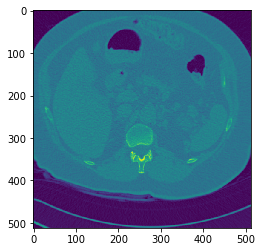

In [50]:
plt.imshow(image[0])

In [ ]:
from skimage import measure, morphology

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [ ]:
plt.imshow(image[3]), plt.imshow(image[20])
plt.show()

In [33]:
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68)#[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208


In [ ]:
x0

In [ ]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [ ]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

In [ ]:
candidatesDf

In [ ]:
from sklearn.model_selection import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [ ]:
X_train

In [ ]:
X_train.to_pickle('traindata')
X_test.to_pickle('testdata')
X_val.to_pickle('valdata')

In [ ]:
print('number of positive cases are ', str(y_train.sum()))
print('total set size is ', str(len(y_train)))
print('percentage of positive cases are ', str(y_train.sum()*1.0/len(y_train)))

In [ ]:
tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1
y_train_new = y_train.append(ytemp)
ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = y_train_new.append(ytemp)

print(len(X_train_new), len(y_train_new))

In [ ]:
X_train_new

In [ ]:
y_train_new.values.astype(int)

In [ ]:
train_filenames = X_train_new.index.to_series().apply(lambda x:'../src/data/train/image_'+str(x)+'.jpg')
train_filenames.values.astype(str)

In [ ]:
np.shape(train_filenames)

In [ ]:
lables

In [ ]:
traindata

In [2]:
import h5py
h5f = h5py.File('../src/data/traindataset1.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('../src/data/valdataset1.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']

In [ ]:
img_width = 50
img_height = 50

In [5]:
np.shape(X_train_images)

(5187, 50, 50, 3)

In [ ]:
plt.imshow(X_train_images[1])

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, ZeroPadding2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import SGD

In [ ]:
X_val_images 

In [1]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape = X_train_images[0].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(2, activation='sigmoid'))

NameError: name 'Sequential' is not defined

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_images , Y_train_labels,  epochs=5, validation_data=(X_val_images, Y_val_labels))

In [ ]:
h5f2 = h5py.File('../src/data/testdataset1.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']

In [ ]:
X_test_images = X_test_images.value
Y_test_labels = Y_test_labels.value

In [ ]:
model.predict(X_test_images)

In [ ]:
y_pred = model.predict_classes(X_test_images)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred[9]

In [ ]:
y_test

In [ ]:
mat = confusion_matrix(Y_test_labels, y_pred)